In [10]:
from utilities import *
from plot_utilities import *
import matlab.engine 
eng = matlab.engine.start_matlab()

In [68]:
def compute_prior_cdf(r, eta, n_samples = 1000, tail_bound = 0.05, n_tail = 5, scale = 1, scipy_int=True, support = False):

    '''
    Returns PPoly-type function that approximates the prior CDF of the signal x
    r : shape parameter controlling rate of exponentional decay
    eta : controls roundedness of peak, and hence sparsity
    scale : scale parameter
    n_samples : number of points used to numerically approximate CDF
    tail_bound : Uses Chebyshev's Inequality to bound the region of the CDF that is outside the coverage of xs
    n_tail : Sets the number of points tha lie outside the coverage of xs to approximate tails if need be

    Usage:
    new_cdf = compute_prior_cdf(r = 0.1, eta = 0.001)
    new_cdf(0.5343) returns CDF
    Can also accept arrays
    '''
    
    beta = (eta + 1.5)/r 
    var_prior = scale * scipy.special.gamma((eta + 1.5 + 2)/r)/scipy.special.gamma(beta)
    cheby = np.sqrt(np.round(var_prior/(tail_bound)))
    
    x_max = min(99, cheby) # introduced additional bound in case chebyshev is unwieldy
    if cheby < 120:
        n_tail = 0
        print("No Tail")
    
    print(cheby)
    xs = np.linspace(-x_max, x_max, n_samples-2*n_tail)
    xs = np.append(-np.logspace(np.log10(cheby), 2, n_tail), xs)
    xs = np.append(xs, np.logspace(2, np.log10(cheby), n_tail))
    prior_pdf = np.full(xs.shape, np.nan)

    # Loop over xs
    for j, x in enumerate(xs):

        # Define integrands
        def gauss_density(theta):
            return (1./(np.sqrt(2*np.pi)*theta)) * np.exp(-0.5*(x/theta)**2)

        def gen_gamma_density(theta):
            return (r/scipy.special.gamma(beta)) * (1/scale) * (theta/scale)**(r*beta - 1) * np.exp(-(theta/scale)**r)

        def integrand(theta):
            return gauss_density(theta) * gen_gamma_density(theta)

        # Integrate 
        if scipy_int:
            prior_pdf[j] = integrate.quad(integrand, 0, np.inf)[0]
        else:
            prior_pdf[j] = prior_pdf[j] = eng.testIntegrals(float(r), float(eta), x, nargout=1)

    prior_cdf = np.zeros_like(prior_pdf)
    prior_cdf[0] = 0
    for i in range(1, len(xs)):
        prior_cdf[i] = (interpolate.CubicSpline(x = xs[:i+1], y = prior_pdf[:i+1])).integrate(xs[0], xs[i])+0
        #prior_cdf[i] = integrate.simps(prior_pdf[:i+1], xs[:i+1])
    normalizer = prior_cdf[-2:-1][0]
    #print(len(xs), len(prior_cdf))
    prior_cdf = prior_cdf/normalizer
    #prior_cdf = np.append(prior_cdf[:-1], 1)
    
   
    poly = interpolate.CubicSpline(x = xs, y = prior_cdf)
    if support:
        return  xs, poly
    else:
        return poly

In [7]:
xs, prior_cdf = compute_prior_cdf(1.4, 1.2, n_samples = 10000, tail_bound = 0.01, n_tail = 100, scipy_int=False, support = True)

No Tail
17.11724276862369


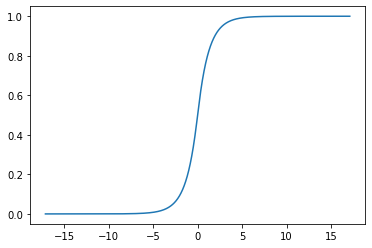

In [8]:
plt.plot(xs, prior_cdf(xs))

In [9]:
n = 10
sample_prior(1.4, 1.2, size = n)

array([ 0.90800331,  3.51524229,  2.5456226 ,  1.48343366, -1.32071774,
        0.01676714,  1.44763284,  1.51873594, -0.26162569,  1.97698289])

In [25]:
def visualize_cdfs(obs_x, null_cdf,  save_plot : bool = False):
    """
    Visualize the gap between the empirical CDF and the true CDF.
    
    Args:
        obs_x (np.ndarray): Observed data.
        r (float): r value.
        eta (float): eta value.
        all_cdfs (dict): Dictionary containing true CDFs.
        
    Returns:
        distance (float): The Kolmogorov-Smirnov statistic.
        location (float): The location of the maximum deviation between the empirical and true CDFs.
    """
    xs = np.linspace(np.min(obs_x), np.max(obs_x), 10000)
    obs_x = np.sort(obs_x)
    n = len(obs_x)
    plt.plot(obs_x, np.arange(1, n+1)/n, label='Empirical CDF')
    plt.plot(xs, null_cdf(xs), label='True CDF')

    distance, pvalue = kstest_custom(obs_x, null_cdf)
    location = kstest_custom(obs_x, null_cdf, return_loc = True)
    emp_cdf_at_loc = np.searchsorted(obs_x, location, side='right') / n
    true_cdf_at_loc = null_cdf(location)
    plt.vlines(location, emp_cdf_at_loc, true_cdf_at_loc, linestyles='--', label=f'Maximum Deviation: {np.round(distance, 6)}')
    


    plt.title(f'Empirical CDF vs True CDF  \n with p-value:{np.round(pvalue, 8)}')
    plt.legend()
    plt.show()

    if save_plot:
        plt.savefig(f'panoptic/plots/ecdf_vs_true_with_{r}_and_{eta}(n={n}).png', dpi = 300, bbox_inches = 'tight')
    
    return distance, location

In [65]:
n = 10000
obs_x = sample_prior(1.4, 1.2, size = n)

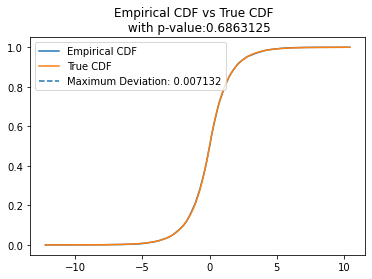

(0.007132395361185373, 0.915300980140586)

In [66]:
visualize_cdfs(obs_x, prior_cdf)

In [73]:
n = 10000
r = 0.2
eta = 1.4
obs_x = sample_prior(r, eta, size = n)
prior_cdf = compute_prior_cdf(r, eta, n_samples = 10000, tail_bound = 0.01, n_tail = 100, scipy_int=False, support = False)

23357984.570025407


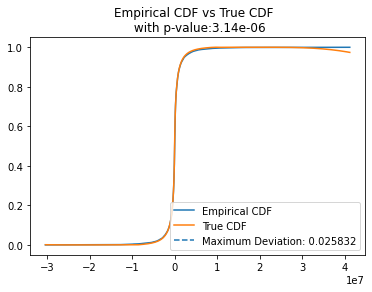

(0.02583166677529325, 3202646.20598558)

In [74]:
visualize_cdfs(obs_x, prior_cdf)